# Lab 2: Stochastic Gradient Descent

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD2"** in the mail subject or I might lose your work (which means 0) and send it to houssam.zenati@inria.fr

Please label your notebook **"L2_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from tqdm import tqdm

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [63]:
from sklearn import model_selection

data = pd.read_csv("w8a.csv", sep=";", header=None)

X = data.iloc[:,:-1].to_numpy()
y = data.iloc[:,-1].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=32)

## Logistic Regression



Today we'll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [64]:
from sklearn.linear_model import LogisticRegression

# Used a max_iter to avoid the warnings of non-convergence
model = LogisticRegression(random_state=0, solver='saga', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

and we compute the accuracy score to evaluate the model performance:

In [65]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9837982701912535


### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [66]:
class StochasticLogisticRegression():
    
    """ Class for logistic regression:
    
    Attributes:                                                                                 
    -----------                                                                              Default value
    coef_         : 1-dimensional np.array, coefficients / weights                         | None                
    lambd_        : float,                  regularization parameter                       | 0.1
    lr_           : float,                  the learning rate                              | 0.01
    bsize         : integer,                the size of the mini-batch >=1                 | 64
    gamma         : float,                  gamma coefficient                              | 0.999
    beta          : float,                  beta coefficient                               | 0.9
    eps           : float,                  epsilon coefficient                            | 10-8
    debias        : boolean,                indicates if we use the debiais correction     | False
    coef_history_ : list,                   the list of all visited betas/ weights         | []
    f_history_    : list ,                  the list of all evaluations in visited betas   | []
    thresh        : float,                  decision threshold for classification          | 0.5
    """
    
    def __init__(self, lambd=0.1, lr=1e-2, batchsize=64, gamma=0.999, beta=0.9, eps=1e-8, debias=False,
                 thresh=0.5):
        self.coef_         = None # weights
        self.lambd_        = lambd
        self.lr_           = lr
        self.bsize_        = batchsize
        self.gamma_        = gamma
        self.beta_         = beta
        self.eps_          = eps
        self.debias_       = debias
        self.coef_history_ = []
        self.f_history_    = []
        self.thresh_       = thresh

    def logistic(self, z):
        return 1 / ( 1 + np.exp( -z ))
    
    def get_params(self, i, g_t, m_t, s_t, method="ADAM"):
        """
        Update the parameters m_t and s_t based on the specified optimization method.

        Parameters:
            i (int): Current iteration number (starting from 0).
            g_t (float or np.array): Current gradient.
            m_t (float or np.array): Previous first moment estimate.
            s_t (float or np.array): Previous second moment estimate.
            method (str): Optimization method ('Vanilla', 'ADAM').

        Returns:
            tuple: Updated (m_t, s_t).
        """

        if method == "Vanilla":
            # Vanilla Gradient Descent
            m_t = g_t
            s_t = 1
            return m_t, s_t

        if method == "ADAM":
            # ADAM optimizer updates
            m_t = self.beta_ * m_t + (1 - self.beta_) * g_t
            s_t = self.gamma_ * s_t + (1 - self.gamma_) * g_t ** 2
            if self.debias_:
                m_t /= (1 - self.beta_ ** (i + 1))
                s_t /= (1 - self.gamma_ ** (i + 1))
            return m_t, s_t
        
        else:
            print("Put another method")
            return 0



        
    def fit(self, X, y, lr=1e-2, bsize=64, max_iter=100, minibatch=False, method="ADAM", penalty="l2"):
        """
        Fit the model to the data (X, y).

        Parameters:
            X (np.array): Design matrix of shape (num_samples, num_features).
            y (np.array): Output vector of shape (num_samples,).
            lr (float): Learning rate. Default is 1e-2.
            bsize (int): Size of the mini-batch (>=1). Default is 64.
            max_iter (int): Number of epochs. Default is 100.
            minibatch (bool): Whether to use mini-batches. Default is False.
            method (str): Optimization method ('Vanilla', 'ADAM'). Default is 'ADAM'.
            penalty (str): Regularization penalty ('l2', 'l1', 'elasticnet'). Default is 'l2'.
        """


        def f(w, penalty):
            # Compute the loss function with the specified penalty
            logits = -y * np.dot(X, w.T)
            loss = np.sum(np.log(1 + np.exp(logits)))
            if penalty == "l2":
                loss += lambd * np.linalg.norm(w) ** 2 / 2
            elif penalty == "l1":
                loss += lambd * np.linalg.norm(w)
            elif penalty == "elasticnet":
                loss += lambd * (np.linalg.norm(w) ** 2 / 2 + np.linalg.norm(w))
            else:
                print("Warning! Wrong penalty name. Using 'l2' penalty.")
                loss += lambd * np.linalg.norm(w) ** 2 / 2
            return loss

        def grad_f(w, batch):
            # Compute the gradient of the loss function for the given batch
            X_batch = X[batch]
            y_batch = y[batch]
            logits = y_batch * np.dot(X_batch, w.T)
            gradient = -np.sum(y_batch * (1 - self.logistic(logits)) * X_batch, axis=0).reshape((1, p))
            gradient += lambd * w
            return gradient

        self.bsize_ = bsize
        self.lr_ = lr
        lambd = self.lambd_
        n, p = X.shape
        y = y.reshape(n, 1)
        self.coef_ = np.random.random((1, p))

        batch_number = max(1, n // self.bsize_)
        m_t = 0
        s_t = 0

        for i in tqdm(range(max_iter)):
            if minibatch:
                indices = np.arange(n)
                np.random.shuffle(indices)
                batches = np.array_split(indices, batch_number)

                for batch in batches:
                    g_t = grad_f(self.coef_, batch)
                    m_t, s_t = self.get_params(i, g_t, m_t, s_t, method)
                    self.coef_ -= lr * m_t / np.sqrt(s_t + self.eps_)
            else:
                g_t = grad_f(self.coef_, np.arange(n))
                m_t, s_t = self.get_params(i, g_t, m_t, s_t, method)
                self.coef_ -= lr * m_t / np.sqrt(s_t + self.eps_)

            loss = f(self.coef_, penalty)
            self.coef_history_.append(self.coef_)
            self.f_history_.append(loss)

        # Update coefficients to those that minimize the loss
        self.coef_ = self.coef_history_[np.argmin(self.f_history_)]
        

    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array, Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array, Predictions (0 or 1)
        """
        return self.logistic(np.dot(X,self.coef_[0].T))

    def accuracy_evaluation(self, X, y, thresh=0.5, margin=0, visualization=True):
        """
        Compute detailed accuracy rates.

        Parameters:
            X (np.array): Input data of shape (num_samples, num_features).
            y (np.array): Labels of the input data of shape (num_samples, ).
            thresh (float): Decision threshold. Default is 0.5.
            margin (float): Margin around the threshold for undetermined labels. Default is 0.
            visualization (bool): Whether to display the results. Default is True.

        Returns:
            dict: A dictionary containing accuracy metrics.
        """
        y_pred = self.predict(X)
        diff = y_pred - (thresh + margin)
        metrics = {}
        # Calculate counts for each category
        metrics['TP'] = np.sum((y == 1) & (diff > 0))
        metrics['UP'] = np.sum((y == 1) & (np.abs(diff) <= 0))
        metrics['FN'] = np.sum((y == 1) & (diff < 0))
        metrics['TN'] = np.sum((y == -1) & (diff < 0))
        metrics['UN'] = np.sum((y == -1) & (np.abs(diff) <= 0))
        metrics['FP'] = np.sum((y == -1) & (diff > 0))

        # Total positive and negative samples
        metrics['P'] = metrics['TP'] + metrics['UP'] + metrics['FN']
        metrics['N'] = metrics['TN'] + metrics['UN'] + metrics['FP']

        # Calculate rates
        epsilon = 1e-12  # To prevent division by zero
        metrics['TP'] /= (metrics['P'] + epsilon)
        metrics['UP'] /= (metrics['P'] + epsilon)
        metrics['FN'] /= (metrics['P'] + epsilon)
        metrics['TN'] /= (metrics['N'] + epsilon)
        metrics['UN'] /= (metrics['N'] + epsilon)
        metrics['FP'] /= (metrics['N'] + epsilon)

        # Overall accuracy metrics
        metrics['good_pred'] = (metrics['TP'] * metrics['P'] + metrics['TN'] * metrics['N']) / len(X)
        metrics['undetermined'] = (metrics['UP'] * metrics['P'] + metrics['UN'] * metrics['N']) / len(X)
        metrics['wrong_pred'] = (metrics['FP'] * metrics['N'] + metrics['FN'] * metrics['P']) / len(X)

        # F1 Score calculation
        metrics['F1_score'] = metrics['TP'] / (metrics['TP'] + 0.5 * (metrics['FP'] + metrics['FN']) + epsilon)

        if visualization:
            print(f"good_pred: {metrics['good_pred']}")
            print(f"undetermined: {metrics['undetermined']}")
            print(f"wrong_pred: {metrics['wrong_pred']}\n")
            print(f"TP: {metrics['TP']}")
            print(f"UP: {metrics['UP']}")
            print(f"FN: {metrics['FN']}")
            print(f"TN: {metrics['TN']}")
            print(f"UN: {metrics['UN']}")
            print(f"FP: {metrics['FP']}")
            print(f"P: {metrics['P']}")
            print(f"N: {metrics['N']}")
            print(f"F1_score: {metrics['F1_score']}")
        return metrics
    
    def find_thresh(self, X, y, step=0.01, margin=0):
        """
        Find the decision threshold that maximizes the F1-score.

        Parameters:
            X (np.array): Input data of shape (num_samples, num_features).
            y (np.array): Labels of the input data of shape (num_samples,).
            step (float): Step size for threshold increments. Default is 0.01.
            margin (float): Margin around the threshold for undetermined labels. Default is 0.
        """
        nb_steps = int(1 / step)
        thresholds = np.linspace(0, 1, num=nb_steps, endpoint=False)
        f_scores = []

        for thresh in tqdm(thresholds):
            metrics_i = self.accuracy_evaluation(X, y, thresh, margin, visualization=False)
            f_scores.append(metrics_i["F1_score"])

        f_scores = np.array(f_scores)
        best_thresh = thresholds[np.argmax(f_scores)]

        # Plotting the F1-score against thresholds
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, f_scores, color='black', linewidth=2)
        plt.axvline(x=best_thresh, color='red', linestyle='--', linewidth=2)
        plt.title("F1-score vs thresholds", fontsize=18)
        plt.xlabel("Threshold", fontsize=14)
        plt.ylabel("F1-score", fontsize=14)
        plt.grid(True, linestyle='--', linewidth=0.4)
        plt.tight_layout()

        # Annotations
        plt.annotate(f'Max F1-Score: {f_scores.max():.3f}',
                     xy=(best_thresh, f_scores.max()),
                     xytext=(best_thresh - 0.2, f_scores.max() - 0.1),
                     arrowprops=dict(arrowstyle='->', color='black'),
                     fontsize=12)

        plt.annotate(f'Best Threshold: {best_thresh:.3f}',
                     xy=(best_thresh, f_scores.max() - 0.05),
                     xytext=(best_thresh - 0.05, f_scores.max() - 0.15),
                     arrowprops=dict(arrowstyle='->', color='black'),
                     fontsize=12)

        plt.show()

Apply to the data

On essaie plusieurs entraînements avec différents coefficients de régularisation, on choisit celui qui minimise
l'erreur sur le test set. On entraine sur 1000 itérations en batch gradient descent. On garde **lambda = 2**.
On essaie ensuite plusieurs learning rates, on choisit le plus grand qui permet d'obtenir un gradient qui converge. On garde **lr = 0.01**.

# ADAM

In [67]:
%time
nb_epochs = 100
model = StochasticLogisticRegression()
model.fit(X_train,y_train,max_iter=nb_epochs, method="ADAM")

CPU times: total: 0 ns
Wall time: 0 ns


100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


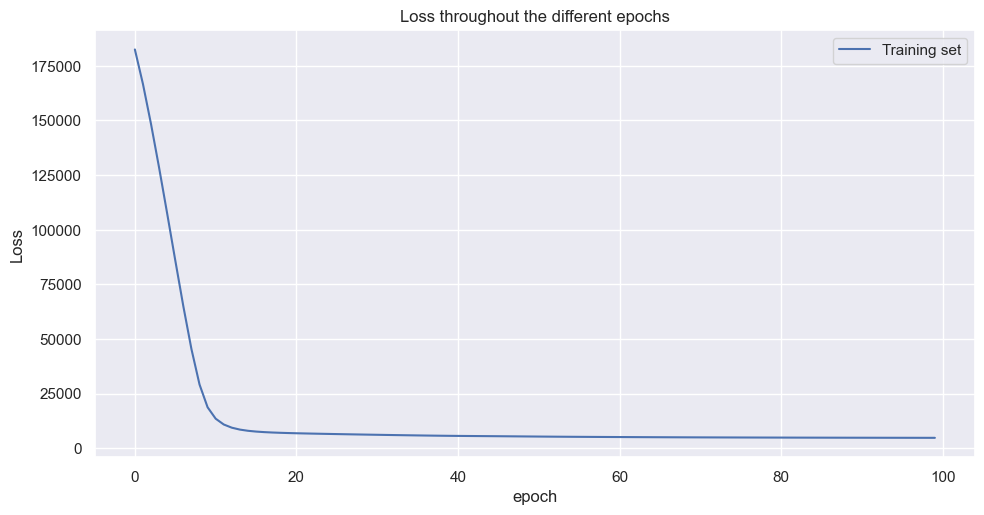

100%|██████████| 100/100 [00:00<00:00, 212.75it/s]


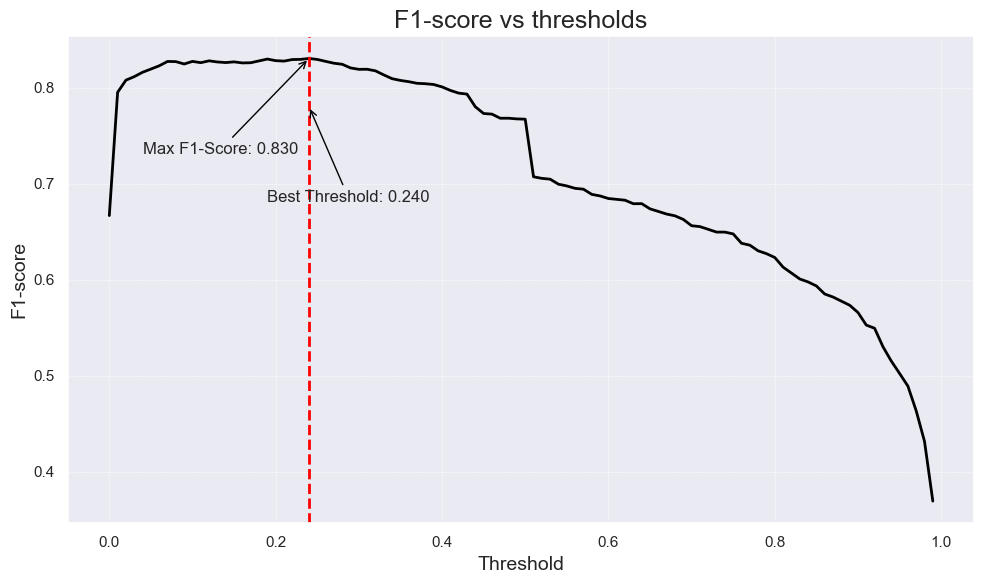

good_pred: 0.898404190522597
undetermined: 0.08649043732488729
wrong_pred: 0.015105372152515511

TP: 0.5599250936329577
UP: 0.10861423220973762
FN: 0.33146067415730274
TN: 0.9097834298665323
UN: 0.08574666330899017
FP: 0.004469906824477461
P: 534
N: 15884
F1_score: 0.7692437018606354


{'TP': np.float64(0.5599250936329577),
 'UP': np.float64(0.10861423220973762),
 'FN': np.float64(0.33146067415730274),
 'TN': np.float64(0.9097834298665323),
 'UN': np.float64(0.08574666330899017),
 'FP': np.float64(0.004469906824477461),
 'P': np.int64(534),
 'N': np.int64(15884),
 'good_pred': np.float64(0.898404190522597),
 'undetermined': np.float64(0.08649043732488729),
 'wrong_pred': np.float64(0.015105372152515511),
 'F1_score': np.float64(0.7692437018606354)}

In [68]:
plt.plot(list(range(len(model.f_history_))), model.f_history_,label="Training set")
plt.title('Loss throughout the different epochs')
plt.legend()
plt.subplots_adjust(right=1.5,top=1)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()
model.find_thresh(X_train,y_train)
model.accuracy_evaluation(X_train,y_train,thresh=model.thresh_,visualization=False)
model.accuracy_evaluation(X_test,y_test,thresh=model.thresh_,visualization=True)

# Vanilla

In [69]:
%%time
#UPGRADE PLOTS
nb_epochs = 100
model = StochasticLogisticRegression()
model.fit(X_train,y_train,max_iter=nb_epochs, method="Vanilla")

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\boist\AppData\Local\Temp\ipykernel_18912\1390853866.py:93: RuntimeWarning: overflow encountered in exp
  loss = np.sum(np.log(1 + np.exp(logits)))
C:\Users\boist\AppData\Local\Temp\ipykernel_18912\1390853866.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / ( 1 + np.exp( -z ))
100%|██████████| 100/100 [00:06<00:00, 15.98it/s]

CPU times: total: 2.2 s
Wall time: 6.26 s


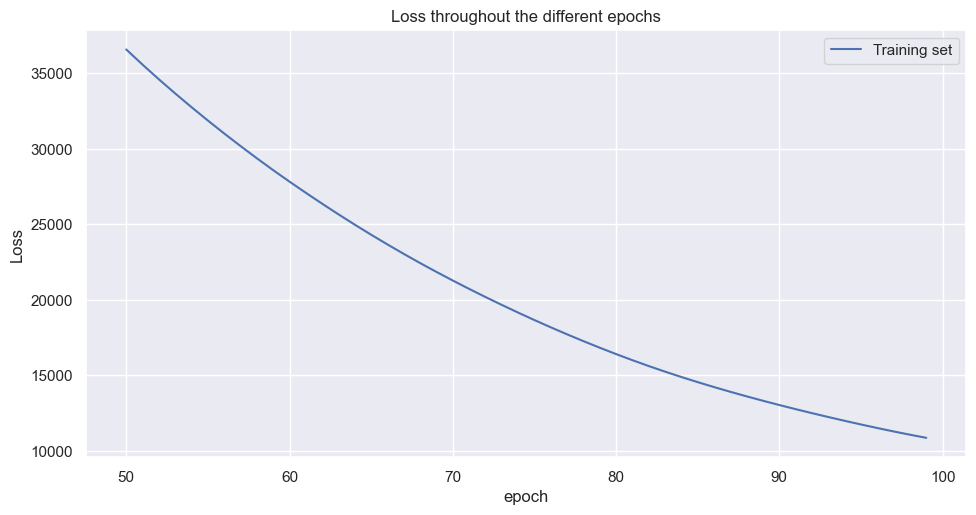

100%|██████████| 100/100 [00:00<00:00, 281.65it/s]


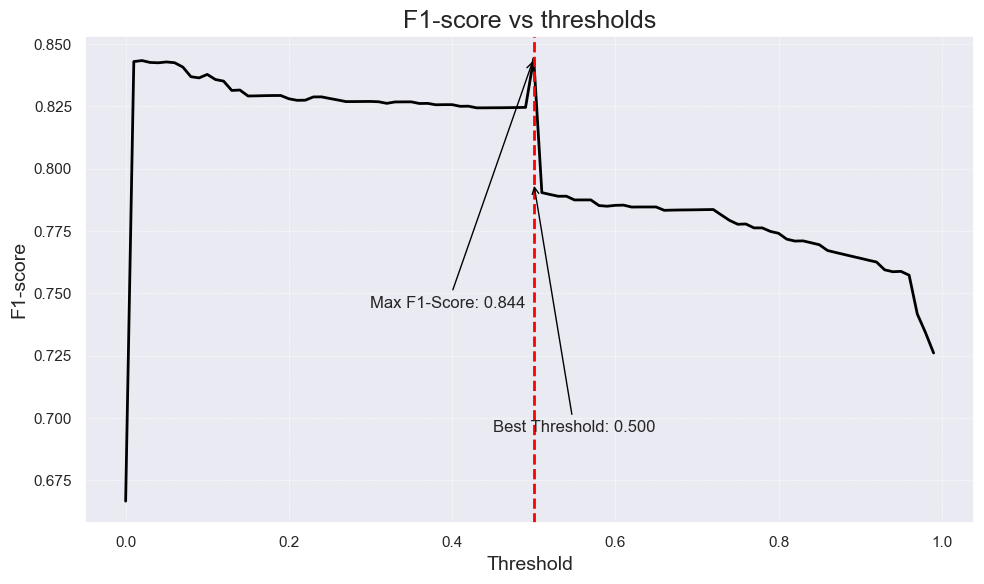

good_pred: 0.8966427649935496
undetermined: 0.08349584470912964
wrong_pred: 0.019861390297320806

TP: 0.6624338624338617
UP: 0.10687830687830677
FN: 0.23068783068783044
TN: 0.903476810967702
UN: 0.08281356141542642
FP: 0.013709627616871488
P: 945
N: 32386
F1_score: 0.844259937117628
good_pred: 0.8932269460348397
undetermined: 0.08649043732488729
wrong_pred: 0.02028261664027286

TP: 0.6704119850187253
UP: 0.10861423220973762
FN: 0.22097378277153515
TN: 0.9007177033492821
UN: 0.08574666330899017
FP: 0.013535633341727523
P: 534
N: 15884
F1_score: 0.8511366430898906


{'TP': np.float64(0.6704119850187253),
 'UP': np.float64(0.10861423220973762),
 'FN': np.float64(0.22097378277153515),
 'TN': np.float64(0.9007177033492821),
 'UN': np.float64(0.08574666330899017),
 'FP': np.float64(0.013535633341727523),
 'P': np.int64(534),
 'N': np.int64(15884),
 'good_pred': np.float64(0.8932269460348397),
 'undetermined': np.float64(0.08649043732488729),
 'wrong_pred': np.float64(0.02028261664027286),
 'F1_score': np.float64(0.8511366430898906)}

In [70]:
plt.plot(list(range(len(model.f_history_))), model.f_history_,label="Training set")
plt.title('Loss throughout the different epochs')
plt.legend()
plt.subplots_adjust(right=1.5,top=1)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()
model.find_thresh(X_train,y_train)
model.accuracy_evaluation(X_train,y_train,thresh=model.thresh_)
model.accuracy_evaluation(X_test,y_test,thresh=model.thresh_)

## Results

Let's check out the results of these specific methods : we have to look at the results knowing that our dataset is pretty unbalanced: actually, 97% of it is made up of label -1 and only a few 1s. This means that getting a good accuracy isn’t too hard for a basic algorithm.

The ADAM as seen in TD is probably the strongest but it is less efficient on the True Positive than on the True Negative.

For the Vanilla Method, whether it’s the training set or the test set, the accuracy stays the same. The accuracy isn’t super high, around 90%, but that means we’re avoiding overfitting.

The performance, whether it’s true positives (TP) or true negatives (TN), is pretty good. To fix the problem of our unbalanced dataset, we could split it into smaller, more balanced sets, or penalize the algorithm during the learning phase when it messes up predicting the 1s.

## Study of the batchsize impact

In [71]:
# --------------------------
# 1. Training the models and storing their loss histories
# --------------------------
import matplotlib.pyplot as plt

# Specify optimization methods you want to compare
methods = ["ADAM", "Vanilla"]

# Create dictionaries to store loss histories, accuracy histories, and models for each method and batch size
loss_histories = {method: {} for method in methods}
trained_models = {method: {} for method in methods}
accuracy_histories_train = {method: {} for method in methods}
accuracy_histories_test = {method: {} for method in methods}

batch_sizes = [None, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]  # None will be used to represent the entire dataset

for method in methods:
    print(f"Optimization method: {method}")
    for batch_size in batch_sizes:
        minibatch = batch_size is not None
        if batch_size == None :
            minibatch = False
        print(f"Using {'entire dataset' if not minibatch else 'Batch size: ' + str(batch_size)} for {method}")
        
        slr = StochasticLogisticRegression()
        # Explicitly set the bsize_ attribute
        if batch_size is None:
            slr.bsize_ = len(X_train)
        else:
            slr.bsize_ = batch_size
            
        slr.coef_ = None  # Reset coefficients for each batch size
        
        # Use the bsize_ attribute instead of batch_size in the fit method
        slr.fit(X_train, y_train, lr=slr.lr_, bsize=slr.bsize_, max_iter=100, minibatch=minibatch, method=method, penalty="l2")
        # Store the loss histories and trained models
        key = "Full Batch" if batch_size is None else batch_size
        loss_histories[method][key] = slr.f_history_
        trained_models[method][key] = slr
        
        # Calculate and store accuracy metrics for train set
        metrics_train = slr.accuracy_evaluation(X_train, y_train, thresh=slr.thresh_,visualization=False)
        accuracy_histories_train[method][key] = metrics_train
        
        # Calculate and store accuracy metrics for test set
        metrics_test = slr.accuracy_evaluation(X_test, y_test, thresh=slr.thresh_,visualization=True)
        accuracy_histories_test[method][key] = metrics_test


Optimization method: ADAM
Using entire dataset for ADAM


100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


good_pred: 0.899135095626751
undetermined: 0.08649043732488729
wrong_pred: 0.014374467048361534

TP: 0.5898876404494371
UP: 0.10861423220973762
FN: 0.3014981273408234
TN: 0.9095316041299419
UN: 0.08574666330899017
FP: 0.00472173256106774
P: 534
N: 15884
F1_score: 0.7939294338886836
Using Batch size: 128 for ADAM


100%|██████████| 100/100 [00:04<00:00, 21.24it/s]


good_pred: 0.8929224022414423
undetermined: 0.08649043732488729
wrong_pred: 0.020587160433670332

TP: 0.5037453183520589
UP: 0.10861423220973762
FN: 0.38764044943820153
TN: 0.906006043817678
UN: 0.08574666330899017
FP: 0.008247292873331653
P: 534
N: 15884
F1_score: 0.7179037754659936
Using Batch size: 256 for ADAM


100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


good_pred: 0.8952369350712631
undetermined: 0.08649043732488729
wrong_pred: 0.01827262760384941

TP: 0.5430711610486881
UP: 0.10861423220973762
FN: 0.3483146067415724
TN: 0.9070763031981868
UN: 0.08574666330899017
FP: 0.007177033492822966
P: 534
N: 15884
F1_score: 0.7534106094026032
Using Batch size: 512 for ADAM


100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


good_pred: 0.8971860153490071
undetermined: 0.08649043732488729
wrong_pred: 0.016323547326105473

TP: 0.5786516853932573
UP: 0.10861423220973762
FN: 0.3127340823970031
TN: 0.9078947368421052
UN: 0.08574666330899017
FP: 0.006358599848904557
P: 534
N: 15884
F1_score: 0.7838705396210728
Using Batch size: 1024 for ADAM


100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


good_pred: 0.8980996467291995
undetermined: 0.08649043732488729
wrong_pred: 0.015409915945913006

TP: 0.6067415730337067
UP: 0.10861423220973762
FN: 0.2846441947565538
TN: 0.9078947368421052
UN: 0.08574666330899017
FP: 0.006358599848904557
P: 534
N: 15884
F1_score: 0.8065765942106962
Using Batch size: 2048 for ADAM


100%|██████████| 100/100 [00:07<00:00, 13.41it/s]


good_pred: 0.898647825557315
undetermined: 0.08649043732488729
wrong_pred: 0.014861737117797522

TP: 0.6217228464419464
UP: 0.10861423220973762
FN: 0.2696629213483141
TN: 0.9079576932762528
UN: 0.08574666330899017
FP: 0.0062956434147569875
P: 534
N: 15884
F1_score: 0.8183771281567468
Using Batch size: 4096 for ADAM


100%|██████████| 100/100 [00:07<00:00, 13.86it/s]


good_pred: 0.8995614569375076
undetermined: 0.08649043732488729
wrong_pred: 0.01394810573760505

TP: 0.638576779026216
UP: 0.10861423220973762
FN: 0.25280898876404445
TN: 0.9083354318811382
UN: 0.08574666330899017
FP: 0.005917904809871568
P: 534
N: 15884
F1_score: 0.8315449009708975
Using Batch size: 8192 for ADAM


100%|██████████| 100/100 [00:06<00:00, 14.42it/s]


good_pred: 0.900109635765623
undetermined: 0.08649043732488729
wrong_pred: 0.013399926909489566

TP: 0.640449438202246
UP: 0.10861423220973762
FN: 0.2509363295880145
TN: 0.9088390833543187
UN: 0.08574666330899017
FP: 0.005414253336691009
P: 534
N: 15884
F1_score: 0.8332407395750625
Using Batch size: 16384 for ADAM


100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


good_pred: 0.8991960043854306
undetermined: 0.08649043732488729
wrong_pred: 0.01431355828968204

TP: 0.6048689138576767
UP: 0.10861423220973762
FN: 0.28651685393258375
TN: 0.909090909090909
UN: 0.08574666330899017
FP: 0.005162427600100729
P: 534
N: 15884
F1_score: 0.8057306795442213
Optimization method: Vanilla
Using entire dataset for Vanilla


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\boist\AppData\Local\Temp\ipykernel_18912\1390853866.py:93: RuntimeWarning: overflow encountered in exp
  loss = np.sum(np.log(1 + np.exp(logits)))
C:\Users\boist\AppData\Local\Temp\ipykernel_18912\1390853866.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / ( 1 + np.exp( -z ))
100%|██████████| 100/100 [00:06<00:00, 15.96it/s]


good_pred: 0.8932878547935192
undetermined: 0.08649043732488729
wrong_pred: 0.02022170788159336

TP: 0.6685393258426954
UP: 0.10861423220973762
FN: 0.22284644194756512
TN: 0.9008436162175774
UN: 0.08574666330899017
FP: 0.013409720473432384
P: 534
N: 15884
F1_score: 0.8498373262293288
Using Batch size: 128 for Vanilla


100%|██████████| 100/100 [00:04<00:00, 22.59it/s]


good_pred: 0.8932269460348397
undetermined: 0.08649043732488729
wrong_pred: 0.02028261664027285

TP: 0.5056179775280889
UP: 0.10861423220973762
FN: 0.38576779026217156
TN: 0.9062578695542683
UN: 0.08574666330899017
FP: 0.007995467136741374
P: 534
N: 15884
F1_score: 0.7197412967141157
Using Batch size: 256 for Vanilla


100%|██████████| 100/100 [00:03<00:00, 25.94it/s]


good_pred: 0.8954196613473017
undetermined: 0.08649043732488729
wrong_pred: 0.01808990132781092

TP: 0.5543071161048678
UP: 0.10861423220973762
FN: 0.33707865168539264
TN: 0.906887433895744
UN: 0.08574666330899017
FP: 0.007365902795265675
P: 534
N: 15884
F1_score: 0.7629520858775994
Using Batch size: 512 for Vanilla


100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


good_pred: 0.8968814715556096
undetermined: 0.08649043732488729
wrong_pred: 0.016628091119502964

TP: 0.6029962546816467
UP: 0.10861423220973762
FN: 0.28838951310861366
TN: 0.9067615210274489
UN: 0.08574666330899017
FP: 0.007491815663560815
P: 534
N: 15884
F1_score: 0.8029918883592058
Using Batch size: 1024 for Vanilla


100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


good_pred: 0.8978560116944816
undetermined: 0.08649043732488729
wrong_pred: 0.015653550980631

TP: 0.6123595505617966
UP: 0.10861423220973762
FN: 0.2790262172284639
TN: 0.9074540418030722
UN: 0.08574666330899017
FP: 0.006799294887937546
P: 534
N: 15884
F1_score: 0.8107798276113469
Using Batch size: 2048 for Vanilla


100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


good_pred: 0.8979778292118406
undetermined: 0.08649043732488729
wrong_pred: 0.015531733463272001

TP: 0.6217228464419464
UP: 0.10861423220973762
FN: 0.2696629213483141
TN: 0.9072651725006294
UN: 0.08574666330899017
FP: 0.006988164190380256
P: 534
N: 15884
F1_score: 0.8180042945506321
Using Batch size: 4096 for Vanilla


100%|██████████| 100/100 [00:07<00:00, 13.63it/s]


good_pred: 0.8982823730052382
undetermined: 0.08649043732488729
wrong_pred: 0.01522718966987451

TP: 0.640449438202246
UP: 0.10861423220973762
FN: 0.2509363295880145
TN: 0.9069503903298917
UN: 0.08574666330899017
FP: 0.007302946361118105
P: 534
N: 15884
F1_score: 0.8322182608780754
Using Batch size: 8192 for Vanilla


100%|██████████| 100/100 [00:06<00:00, 14.29it/s]


good_pred: 0.8989523693507125
undetermined: 0.08649043732488729
wrong_pred: 0.014557193324400032

TP: 0.6647940074906354
UP: 0.10861423220973762
FN: 0.22659176029962502
TN: 0.9068244774615964
UN: 0.08574666330899017
FP: 0.007428859229413245
P: 534
N: 15884
F1_score: 0.850332996143866
Using Batch size: 16384 for Vanilla


100%|██████████| 100/100 [00:06<00:00, 14.86it/s]

good_pred: 0.8979778292118406
undetermined: 0.08649043732488729
wrong_pred: 0.015531733463272005

TP: 0.6797752808988751
UP: 0.10861423220973762
FN: 0.21161048689138537
TN: 0.9053135230420548
UN: 0.08574666330899017
FP: 0.008939813648954922
P: 534
N: 15884
F1_score: 0.860420112539075


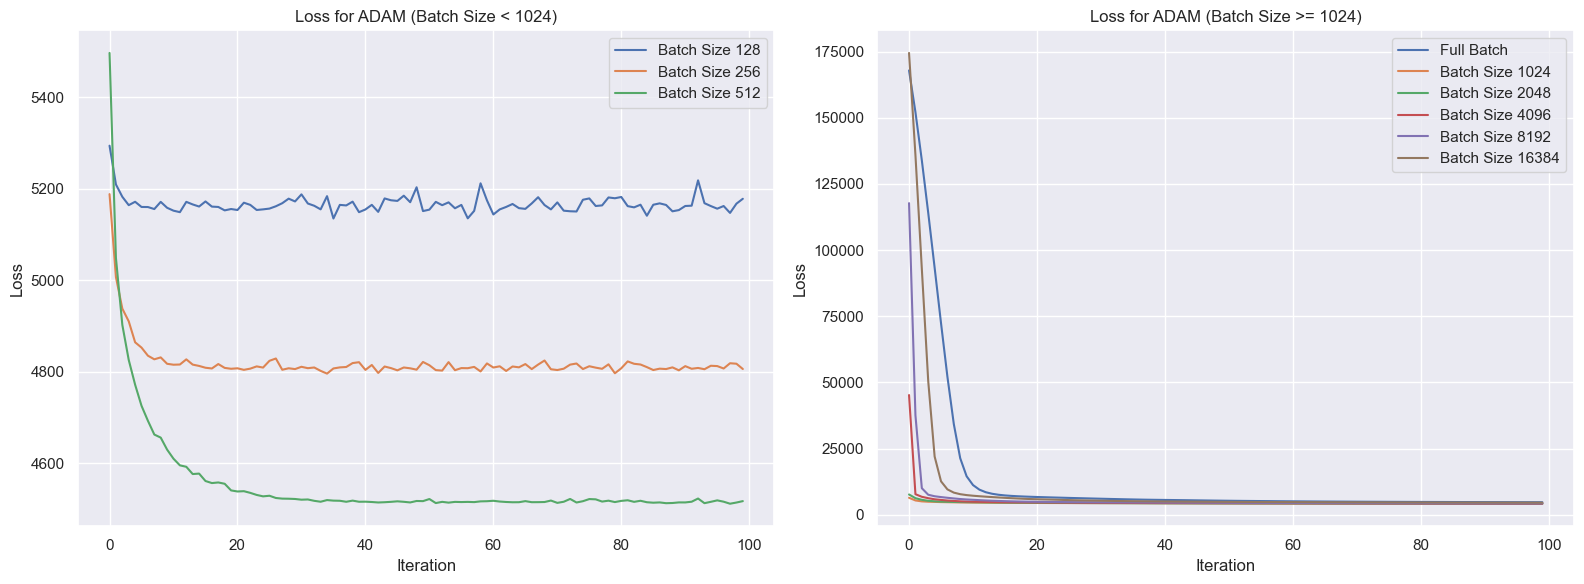

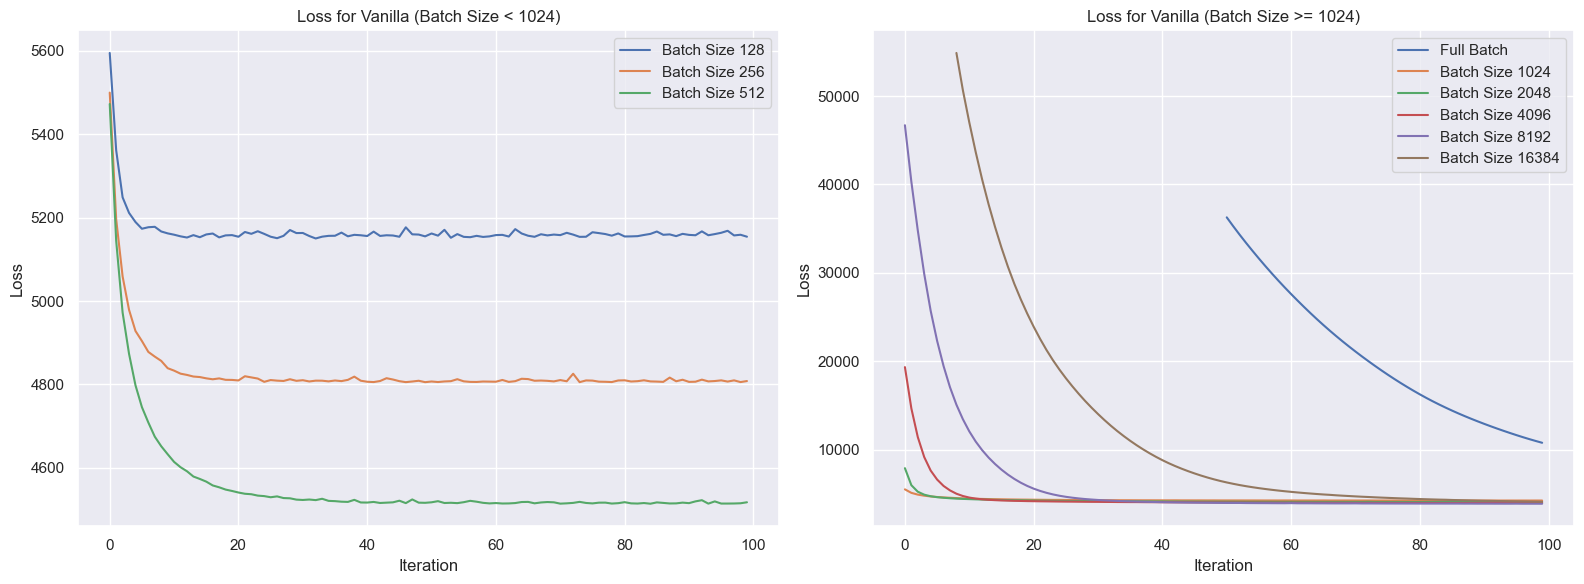

In [72]:
import matplotlib.pyplot as plt

# Define batch size categories
batch_sizes_under_1024 = [batch for batch in batch_sizes if batch is not None and batch < 1024]
batch_sizes_1024_and_above = [batch for batch in batch_sizes if batch is None or batch >= 1024]

for method in methods:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Plot for batch sizes under 1024
    axes[0].set_title(f"Loss for {method} (Batch Size < 1024)")
    for batch_size, loss_values in loss_histories[method].items():
        if batch_size in batch_sizes_under_1024:
            axes[0].plot(loss_values, label=f"Batch Size {batch_size}")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Plot for 'Full Batch' and batch sizes 1024 and above
    axes[1].set_title(f"Loss for {method} (Batch Size >= 1024)")
    for batch_size, loss_values in loss_histories[method].items():
        if batch_size == 'Full Batch':
            axes[1].plot(loss_values, label="Full Batch")
        elif batch_size in batch_sizes_1024_and_above:
            axes[1].plot(loss_values, label=f"Batch Size {batch_size}")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


# Results :

Vanilla: we can see that more the batch size is small more the loss converge fast. however under 1024 rows the loss is just a noise and the algorithm do not learn. 

Adam : same as the vanilla but the convergences for large batchs are smaller that in Vanilla

As a conclusion, more the batchs are big more the convergence is close to the no-minibatch method. Futhermore, more the batchs are small more the convergence is fast but there is a treashold due to the bad repartition of datas: is the batch is too small, the algorithm gonna train with only -1 data. 

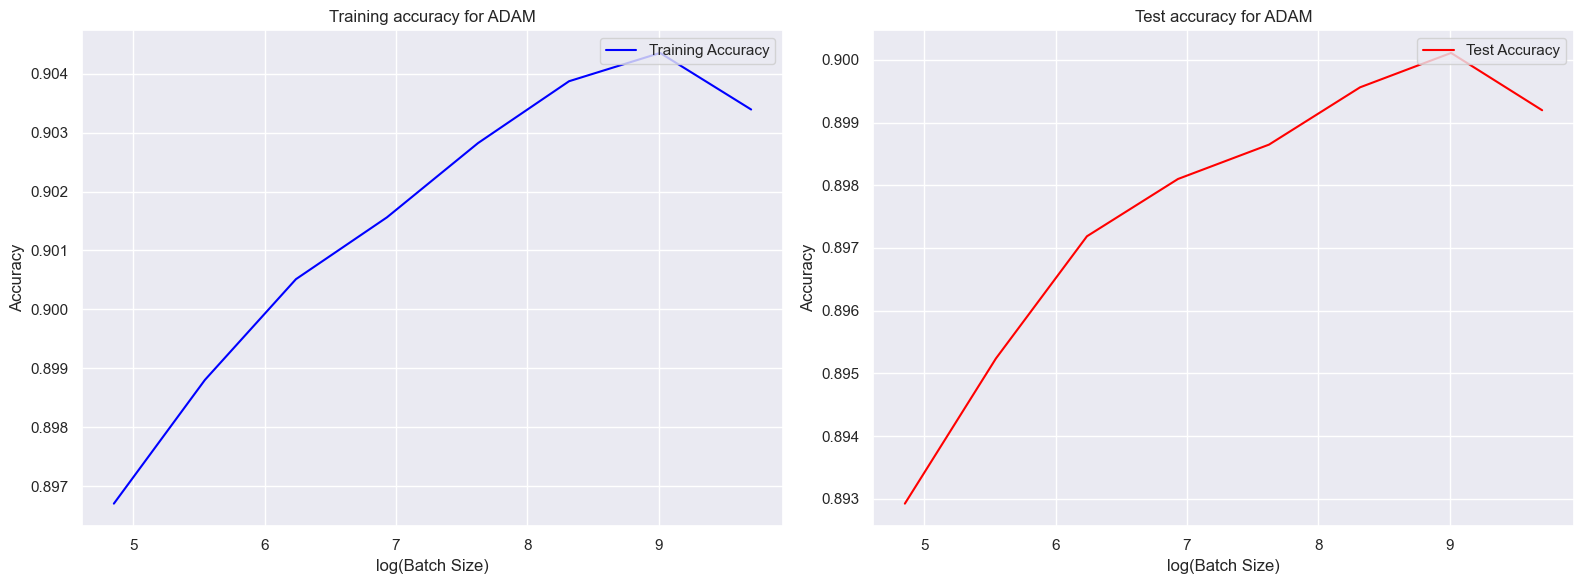

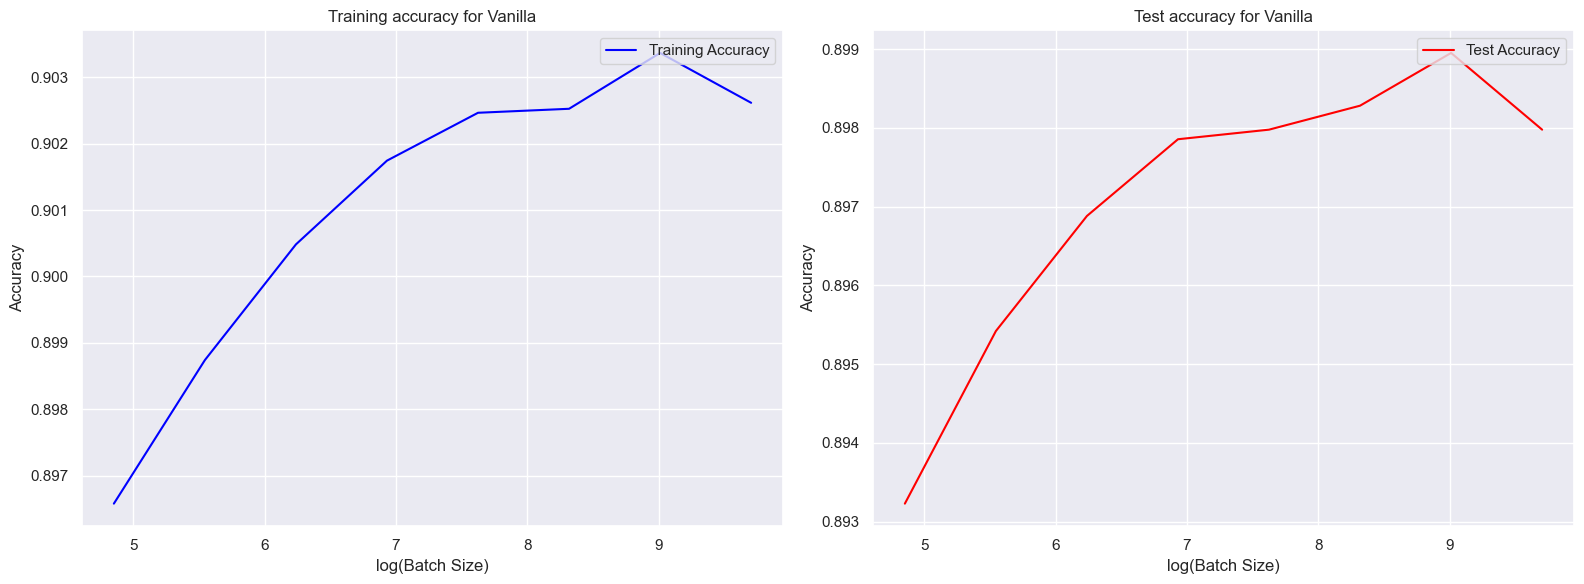

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Extract methods and batch sizes from the accuracy_histories
methods = list(accuracy_histories_train.keys())
batch_sizes = list(accuracy_histories_train[methods[0]].keys())[1:]

# Assuming accuracy_histories_test has the same structure as accuracy_histories_train but for test data

# Logarithmically scaled batch sizes for x-axis
log_batch_sizes = np.log(batch_sizes)

for method in methods:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Training F1
    acc_train = [accuracy_histories_train[method][batch]['good_pred'] for batch in batch_sizes]
    axes[0].plot(log_batch_sizes, acc_train, color='blue', label='Training Accuracy')
    axes[0].set_title(f"Training accuracy for {method}")
    axes[0].set_xlabel("log(Batch Size)")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend(loc='upper right')
    axes[0].grid(True)

    # Test F1
    acc_test = [accuracy_histories_test[method][batch]['good_pred'] for batch in batch_sizes]
    axes[1].plot(log_batch_sizes, acc_test, color='red', label='Test Accuracy')
    axes[1].set_title(f"Test accuracy for {method}")
    axes[1].set_xlabel("log(Batch Size)")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend(loc='upper right')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


# Result

There is a threshold for which the training and test accuracy seems to downgrade a bit, but overall, the trend is the same that F1 score, the bigger the batch size, the more accurate is the model. As opposed to the loss.

## Gamma impact

100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


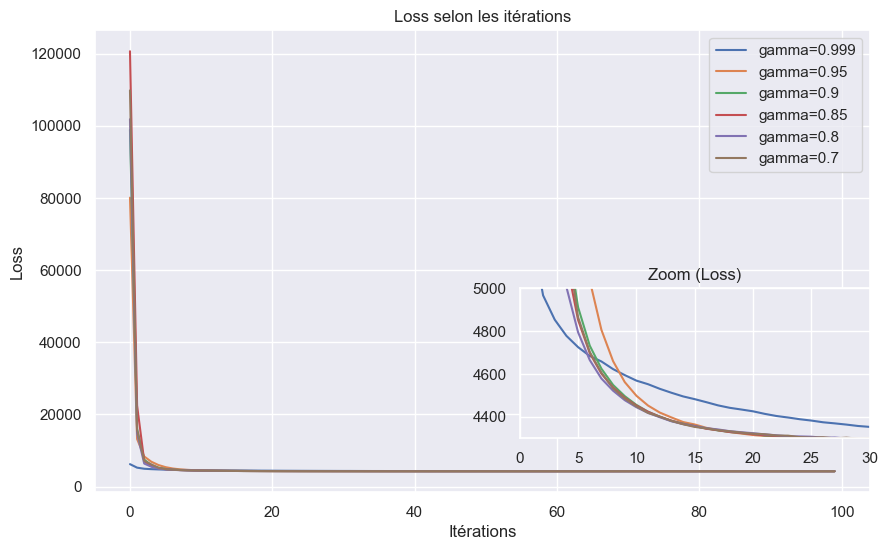

In [74]:
#TODO : Study Loss and F1-score

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Liste des valeurs de "Gamma" à tester
gamma_values = [0.999, 0.95, 0.9, 0.85, 0.8, 0.7]

# Paramètres communs pour tous les modèles
beta = 0.9
nb_epochs = 100
batch_size = 1024

# séparation en un train et test set
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=32)

# stockage des loss
loss_history = {}

# Graphe des Loss
plt.figure(figsize=(10, 6))

# Graphe Zoom
ax_main = plt.subplot(1, 1, 1)
ax_zoom = plt.axes([0.55, 0.2, 0.35, 0.25]) 

# stockage des modèles pour les analyses F1
modeles = []

# on parcours les différentes valeurs de gamma
for gamma in gamma_values:
    model = StochasticLogisticRegression(debias=False, gamma=gamma, beta=beta)
    model.fit(X_train, y_train, bsize=batch_size, max_iter=nb_epochs, minibatch=True)

    # ajout à la liste des modèles
    modeles.append(model)

    # ajout de la courbe de zoom
    ax_zoom.plot(list(range(len(model.f_history_))), model.f_history_, label=f"gamma={gamma}")
    # ajout sur le graphique principal
    ax_main.plot(list(range(len(model.f_history_))), model.f_history_, label=f"gamma={gamma}")

# TGraphique Principal
ax_main.set_title("Loss selon les itérations")
ax_main.set_xlabel("Itérations")
ax_main.set_ylabel("Loss")
ax_main.legend()

# Grahique Zoom
ax_zoom.set_title("Zoom (Loss)")
ax_zoom.set_xlim(0, 30) 
ax_zoom.set_ylim(4300, 5000)  


plt.show()


# Result

All the gamma values oscillate to a greater or lesser extent, and converge at nearly same speeds. 

On closer inspection, although the gamma value 0.999 oscillates for a small number of iterations, it tends to stabilise and converge more quickly than the other values, but after that the convergence is impacted all the other values are getting faster after 8/9 iterations.

100%|██████████| 100/100 [00:00<00:00, 156.35it/s]


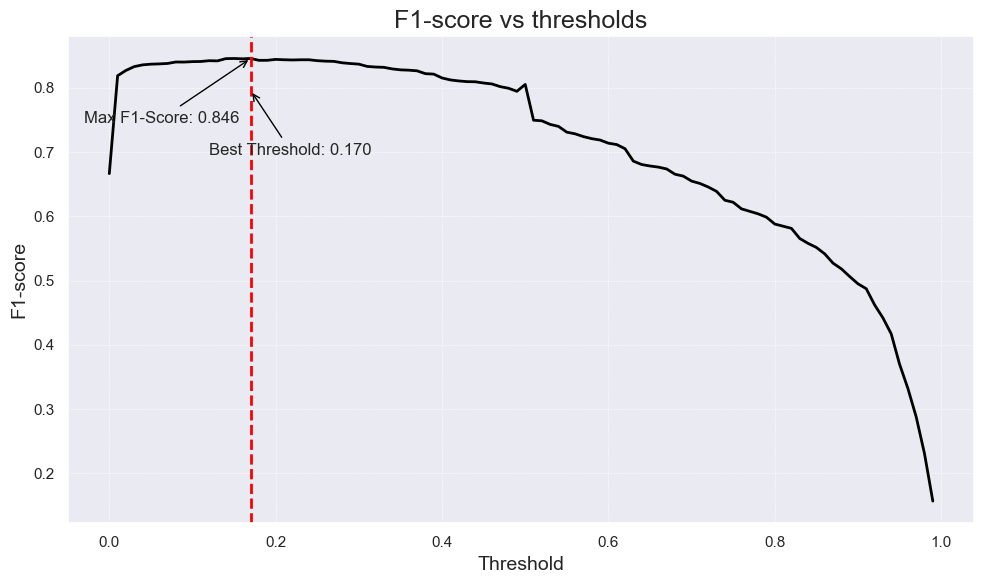

good_pred: 0.9004000080403626
undetermined: 0.0844841102333715
wrong_pred: 0.01511588172626585

TP: 0.606490872210953
UP: 0.10750507099391474
FN: 0.2860040567951317
TN: 0.9094054278019473
UN: 0.08377874456183965
FP: 0.006815827636212969
P: 1479
N: 48270
F1_score: 0.8055388712416562


100%|██████████| 100/100 [00:00<00:00, 155.78it/s]


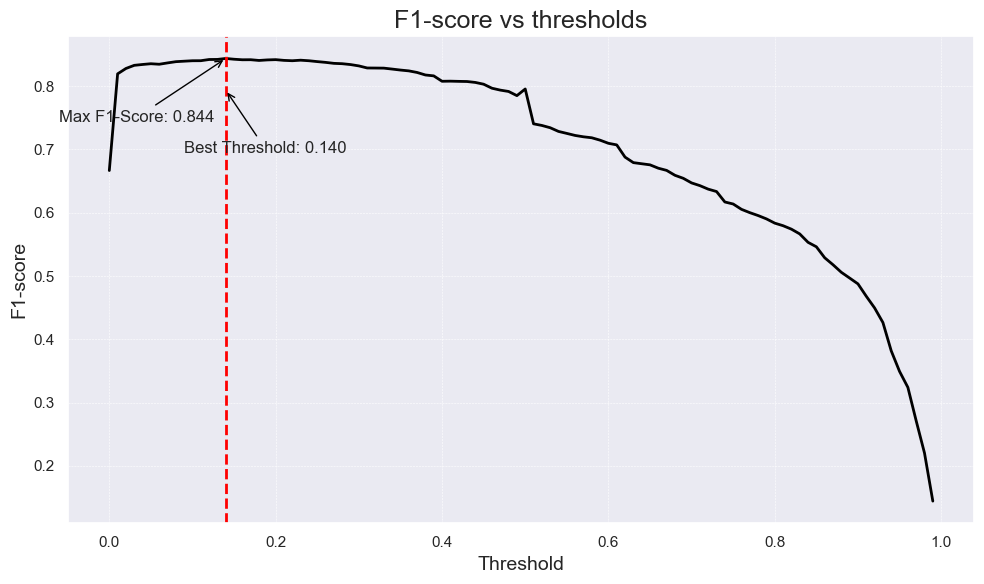

good_pred: 0.900500512573117
undetermined: 0.0844841102333715
wrong_pred: 0.015015377193511422

TP: 0.5936443542934412
UP: 0.10750507099391474
FN: 0.2988505747126435
TN: 0.9099026310337683
UN: 0.08377874456183965
FP: 0.006318624404391962
P: 1479
N: 48270
F1_score: 0.7955257581849554


100%|██████████| 100/100 [00:00<00:00, 161.29it/s]


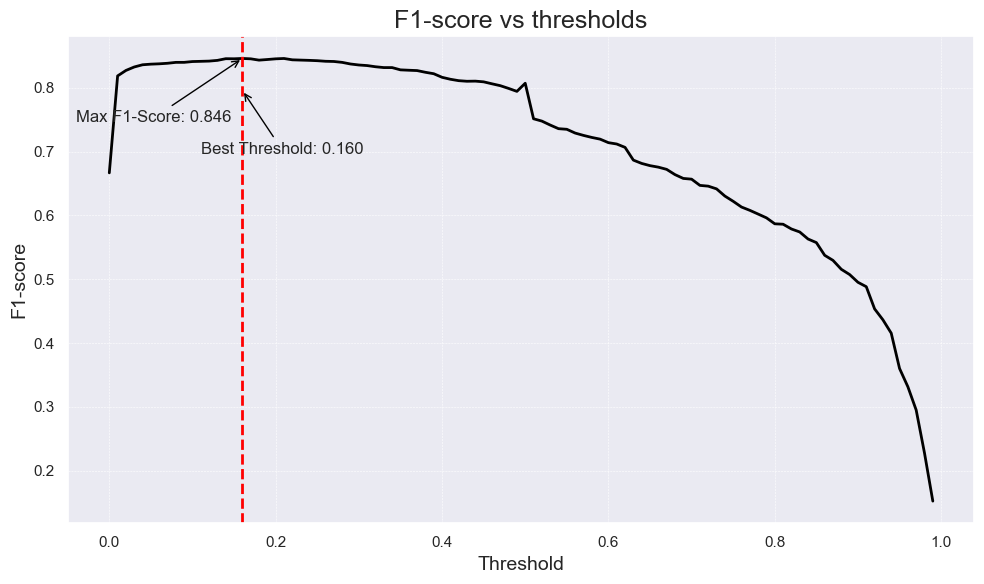

good_pred: 0.9003598062272609
undetermined: 0.0844841102333715
wrong_pred: 0.01515608353936762

TP: 0.6085192697768759
UP: 0.10750507099391474
FN: 0.28397565922920875
TN: 0.909301843795318
UN: 0.08377874456183965
FP: 0.006919411642842345
P: 1479
N: 48270
F1_score: 0.8070902665326734


100%|██████████| 100/100 [00:00<00:00, 167.26it/s]


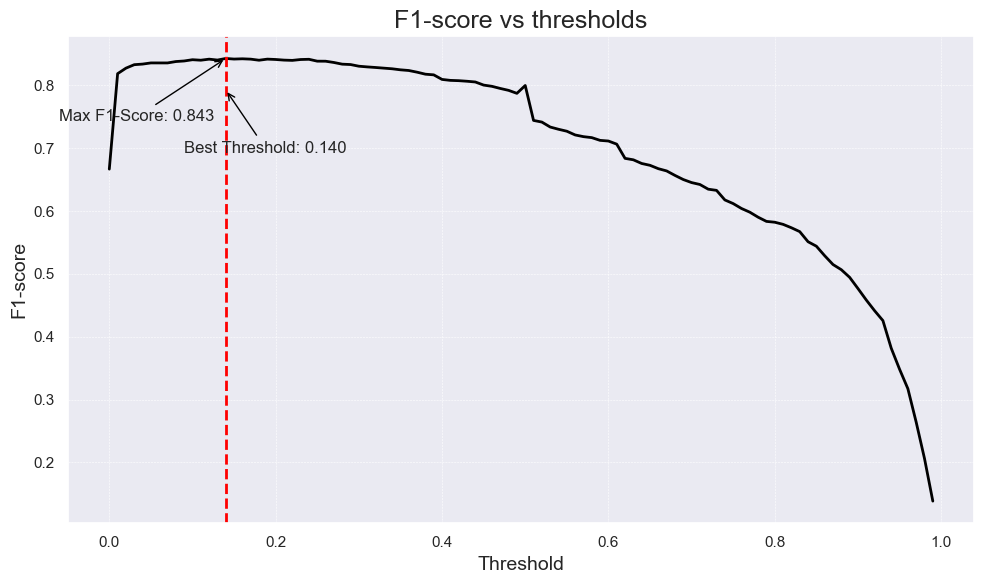

good_pred: 0.9003598062272609
undetermined: 0.0844841102333715
wrong_pred: 0.01515608353936762

TP: 0.5990534144692357
UP: 0.10750507099391474
FN: 0.293441514536849
TN: 0.9095918790138803
UN: 0.08377874456183965
FP: 0.006629376424280091
P: 1479
N: 48270
F1_score: 0.7997094156607552


100%|██████████| 100/100 [00:00<00:00, 166.28it/s]


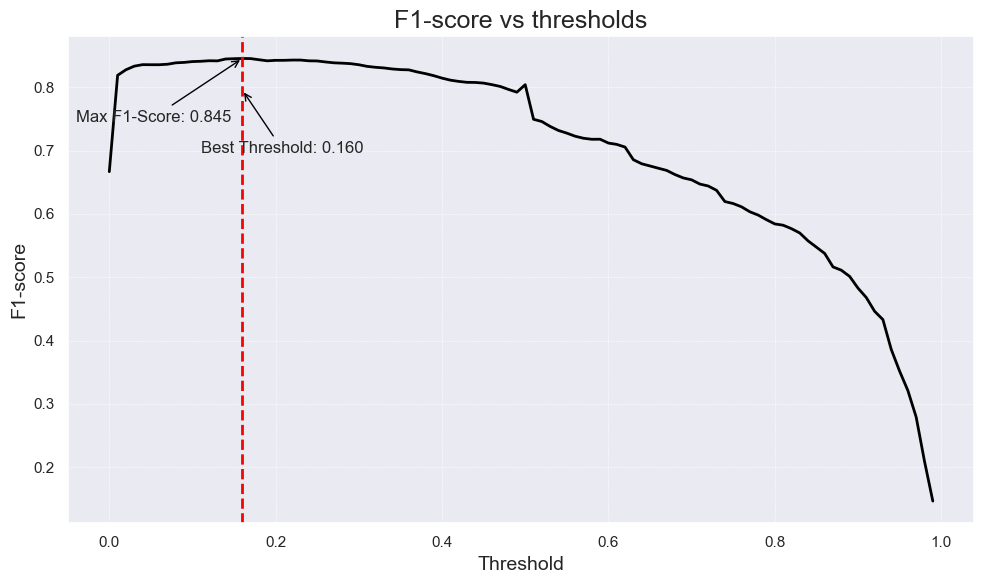

good_pred: 0.9004402098534644
undetermined: 0.0844841102333715
wrong_pred: 0.015075679913164079

TP: 0.60446247464503
UP: 0.10750507099391474
FN: 0.28803245436105457
TN: 0.9095090118085768
UN: 0.08377874456183965
FP: 0.006712243629583592
P: 1479
N: 48270
F1_score: 0.8039830766516599


100%|██████████| 100/100 [00:00<00:00, 164.37it/s]


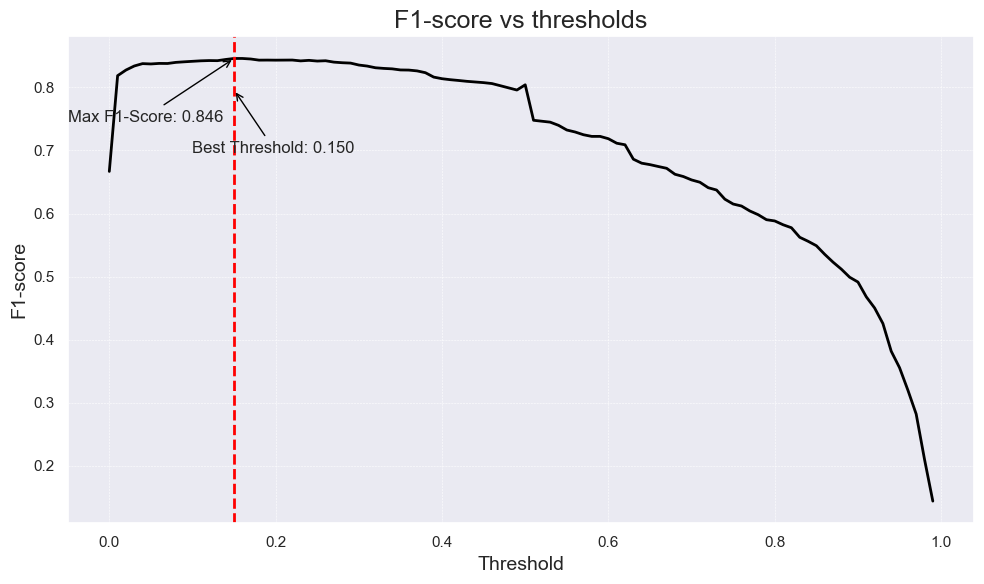

good_pred: 0.900319604414159
undetermined: 0.0844841102333715
wrong_pred: 0.015196285352469393

TP: 0.60446247464503
UP: 0.10750507099391474
FN: 0.28803245436105457
TN: 0.9093847110006215
UN: 0.08377874456183965
FP: 0.006836544437538844
P: 1479
N: 48270
F1_score: 0.8039166209074159


In [75]:
# on trace pour chaque valeur de gamma le graphe du F1 score selon les différents thresholds
score = []
for model in modeles:
    model.find_thresh(X,y)
    score.append(model.accuracy_evaluation(X,y,thresh=model.thresh_))

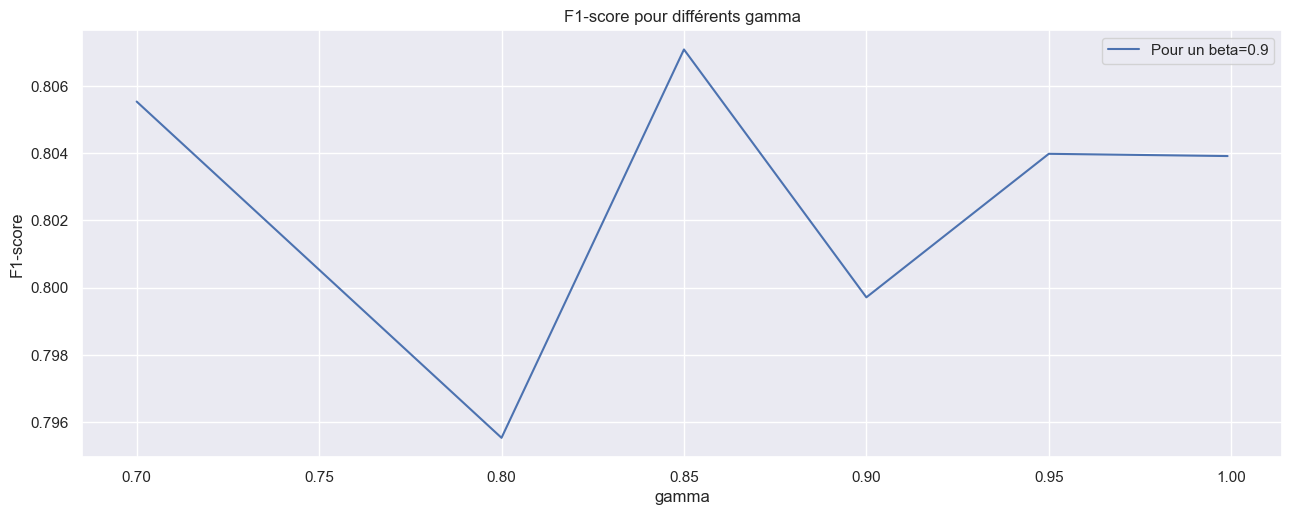

In [76]:
# on représente maintenant tous les F1 score selon les gamma
f1_score = [Fscore['F1_score'] for Fscore in score]
gamma = [0.7, 0.8, 0.85,0.9,0.95,0.999 ]
plt.plot(gamma, f1_score,label="Pour un beta=0.9")
plt.title('F1-score pour différents gamma')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('F1-score')
plt.subplots_adjust(right=2,top=1)
plt.show()

# Result

The value we should take for gamma looks like the 0.999 value should be relevant here even if 0.90 looks like its better, we feel more comfortable using the default value

## Beta impact
Nous allons comparer les paramètres beta pour gamma = 0.999 et batch_size=1024

In [ ]:
#TODO : Study Loss and F1-score
# Liste des valeurs de "Beta" à tester
beta_values = [0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
gamma = 0.999

# Paramètres pour tous les modèles
nb_epochs = 100
batch_size = 1024

# test & train set
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=32)

# stockage des Loss
loss_history = {}

# Plot en sortie
plt.figure(figsize=(15, 10))

# Graphe Zoom
ax_main = plt.subplot(1, 1, 1)
ax_zoom = plt.axes([0.55, 0.2, 0.35, 0.45]) 

# Liste pour stocker les modèles
modeles = []

for beta in beta_values:
    model = StochasticLogisticRegression(debias=False, gamma=gamma, beta=beta)
    model.fit(X_train, y_train, bsize=batch_size, max_iter=nb_epochs, minibatch=True)

    # Tracez la courbe de zoom
    ax_zoom.plot(list(range(len(model.f_history_))), model.f_history_, label=f"gamma={gamma}")

    # Tracez la courbe sur le graphique principal
    ax_main.plot(list(range(len(model.f_history_))), model.f_history_, label=f"beta={beta}")

    # ajout a la liste des modèles
    modeles.append(model)

# Titre et légende du graphique principal
ax_main.set_title("Loss selon les itérations avec différentes valeurs de Beta")
ax_main.set_xlabel("Itérations")
ax_main.set_ylabel("Loss")
ax_main.legend()

# Titre et légende du graphique de zoom
ax_zoom.set_title("Zoom (Loss)")
ax_zoom.set_xlim(0, 50)  # Limite de l'axe x du zoom
ax_zoom.set_ylim(4000, 6000)  # Limite de l'axe y du zoom


plt.show()


 18%|█▊        | 18/100 [00:01<00:06, 13.19it/s]

In [ ]:
# on trace les différens grpahe de F1 score en fonction des threshold
scores = []
for model in modeles:
    model.find_thresh(X,y)
    scores.append(model.accuracy_evaluation(X,y,thresh=model.thresh_))

In [ ]:
f1_scores = [score['F1_score'] for score in scores]
beta = [0.7, 0.8, 0.85, 0.9,0.95,0.999]
plt.plot(beta, f1_scores,label="Beta = 0.999")
plt.title('F1-score for different beta')
plt.legend()
plt.xlabel('beta')
plt.ylabel('F1-score')
plt.subplots_adjust(right=1.5,top=1)
plt.show()

# Result :

For this differents Beta values, the F1 score stays around 0.62. We should take a 0.85

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Liste des valeurs de "Batch Size" à tester
batch_size_values = [32, 64, 128, 256, 512, 1024]
gamma = 0.999
beta = 0.85

# Paramètres pour tous les modèles
nb_epochs = 100

# test & train set
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=32)

# stockage des Loss
loss_history = {}

# Plot en sortie
plt.figure(figsize=(15, 10))

# Graphe Zoom
ax_main = plt.subplot(1, 1, 1)

# Liste pour stocker les modèles
modeles = []

for batch_size in batch_size_values:
    model = StochasticLogisticRegression(debias=False, gamma=gamma, beta=beta)
    model.fit(X_train, y_train, bsize=batch_size, max_iter=nb_epochs, minibatch=True)


    # Tracez la courbe sur le graphique principal
    ax_main.plot(list(range(len(model.f_history_))), model.f_history_, label=f"Batch Size={batch_size}")

    # ajout à la liste des modèles
    modeles.append(model)

# Titre et légende du graphique principal
ax_main.set_title("Loss selon les itérations avec différentes valeurs de Batch Size")
ax_main.set_xlabel("Itérations")
ax_main.set_ylabel("Loss")
ax_main.legend()



plt.show()